# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
from joblib import dump, load
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import datetime

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('../Datasets/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [18]:
reviewDF = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
reviewDF = reviewDF[:100000]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [2]:
reviewDF = pd.read_pickle('../Datasets/reviewDF')

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
rLength = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    rLength.append(len(sentance.split(' ')))

100%|██████████| 100000/100000 [00:45<00:00, 2181.26it/s]


In [6]:
preprocessed_reviews[150]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='../Datasets/train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='../Datasets/confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='../Datasets/summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [7]:
# Save to file in the current working directory
def saveModel(fileName,model):  
    with open(fileName, 'wb') as file:  
        pickle.dump(model, file)

In [8]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:  
        pickle_model = pickle.load(file)
    return pickle_model

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [20]:
#Forming separate datafrmae
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews,
     'length': rLength,
     'Score' : reviewDF['Score']
    })
X = Dataset.iloc[:,:2].values
Y = Dataset.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

X_trainText = np.array(X_train[:,:1])
X_trainText = X_trainText.reshape(X_trainText.shape[0],)

X_testText  = np.array(X_test[:,:1])
X_testText  = X_testText.reshape(X_testText.shape[0],) 

In [31]:
# BOW vectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (67000, 37714)
Test Data Size:   (33000, 37714)


In [32]:
# Model Training
clf = RandomForestClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=10,verbose=10, scoring='roc_auc')
model.fit(X_train_bow, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 10 folds for each of 63 candidates, totalling 630 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.5048809437947556, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5089626500437897, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5546902630791414, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5198892233266638, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5074910489117307, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5042846920108394, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5071223292038375, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5033765986441667, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5032209737827715, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.503030303030303, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.5057130493019422, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.50562670650662, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.5013049462440055, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.5105288128997898, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.5142471316533401, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.5285790750226096, total=   0.2s
[CV] max_depth=1, n_estimators=2 ...................

[CV]  max_depth=1, n_estimators=64, score=0.7721860441342445, total=   0.8s
[CV] max_depth=1, n_estimators=64 ....................................
[CV]  max_depth=1, n_estimators=64, score=0.7524604672290827, total=   0.8s
[CV] max_depth=1, n_estimators=64 ....................................
[CV]  max_depth=1, n_estimators=64, score=0.7637946307485444, total=   0.7s
[CV] max_depth=1, n_estimators=64 ....................................
[CV]  max_depth=1, n_estimators=64, score=0.7388703170623497, total=   0.7s
[CV] max_depth=1, n_estimators=64 ....................................
[CV]  max_depth=1, n_estimators=64, score=0.7190865756647167, total=   0.7s
[CV] max_depth=1, n_estimators=100 ...................................
[CV]  max_depth=1, n_estimators=100, score=0.8083044665395909, total=   1.1s
[CV] max_depth=1, n_estimators=100 ...................................
[CV]  max_depth=1, n_estimators=100, score=0.810094894647365, total=   1.1s
[CV] max_depth=1, n_estimators=100 ......

[CV]  max_depth=5, n_estimators=8, score=0.6982685075472671, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.6619351416056807, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.6889405110220194, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.6774827882712096, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.7328284614515808, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.6683891792204495, total=   0.3s
[CV] max_depth=5, n_estimators=8 .....................................
[CV]  max_depth=5, n_estimators=8, score=0.6657082839714719, total=   0.3s
[CV] max_depth=5, n_estimators=8 ................

[CV]  max_depth=5, n_estimators=200, score=0.8836800617651884, total=   3.2s
[CV] max_depth=5, n_estimators=200 ...................................
[CV]  max_depth=5, n_estimators=200, score=0.8895562365225287, total=   3.3s
[CV] max_depth=5, n_estimators=200 ...................................
[CV]  max_depth=5, n_estimators=200, score=0.8825650787754975, total=   3.3s
[CV] max_depth=10, n_estimators=1 ....................................
[CV]  max_depth=10, n_estimators=1, score=0.5898191746947608, total=   0.2s
[CV] max_depth=10, n_estimators=1 ....................................
[CV]  max_depth=10, n_estimators=1, score=0.6405954355777652, total=   0.2s
[CV] max_depth=10, n_estimators=1 ....................................
[CV]  max_depth=10, n_estimators=1, score=0.5471745847626632, total=   0.2s
[CV] max_depth=10, n_estimators=1 ....................................
[CV]  max_depth=10, n_estimators=1, score=0.5496248498533778, total=   0.2s
[CV] max_depth=10, n_estimators=1 .....

[CV]  max_depth=10, n_estimators=32, score=0.8669856535263124, total=   1.1s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.8658639335653239, total=   1.1s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.8719063818806725, total=   1.1s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.858832805295384, total=   1.0s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.8566882952000073, total=   1.0s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.8554363863352628, total=   1.0s
[CV] max_depth=10, n_estimators=32 ...................................
[CV]  max_depth=10, n_estimators=32, score=0.8664340029508568, total=   1.0s
[CV] max_depth=10, n_estimators=64 .

[CV]  max_depth=50, n_estimators=2, score=0.7112288358560064, total=   0.5s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.7895819895935294, total=   1.0s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.7999484828190202, total=   1.0s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.7981530625788863, total=   1.2s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.8039445795111383, total=   1.1s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.7914639635740379, total=   1.1s
[CV] max_depth=50, n_estimators=4 ....................................
[CV]  max_depth=50, n_estimators=4, score=0.7985574382451168, total=   1.2s
[CV] max_depth=50, n_estimators=4 ........

[CV]  max_depth=50, n_estimators=100, score=0.916926563565299, total=  24.3s
[CV] max_depth=50, n_estimators=100 ..................................
[CV]  max_depth=50, n_estimators=100, score=0.9154088151421993, total=  24.6s
[CV] max_depth=50, n_estimators=100 ..................................
[CV]  max_depth=50, n_estimators=100, score=0.9209393016048891, total=  23.7s
[CV] max_depth=50, n_estimators=100 ..................................
[CV]  max_depth=50, n_estimators=100, score=0.9175048751044665, total=  25.4s
[CV] max_depth=50, n_estimators=100 ..................................
[CV]  max_depth=50, n_estimators=100, score=0.9183402977682855, total=  23.5s
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9178362783988461, total=  46.6s
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9296687445262997, total=  47.0s
[CV] max_depth=50, n_estimato

[CV]  max_depth=100, n_estimators=16, score=0.8909890268404513, total=   8.8s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8823372954728886, total=   9.6s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8776957347229676, total=   9.2s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8931951530980288, total=   9.3s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8820092812665656, total=   9.4s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8779736657045741, total=   9.1s
[CV] max_depth=100, n_estimators=16 ..................................
[CV]  max_depth=100, n_estimators=16, score=0.8864154714706991, total=   9.3s
[CV] max_depth=100, n_estima

[CV]  max_depth=500, n_estimators=1, score=0.6251816805044761, total=   1.3s
[CV] max_depth=500, n_estimators=1 ...................................
[CV]  max_depth=500, n_estimators=1, score=0.6301006569764902, total=   1.2s
[CV] max_depth=500, n_estimators=1 ...................................
[CV]  max_depth=500, n_estimators=1, score=0.60221613479019, total=   1.3s
[CV] max_depth=500, n_estimators=1 ...................................
[CV]  max_depth=500, n_estimators=1, score=0.5933208489388264, total=   1.4s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.6712594920405955, total=   2.4s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.6706114059038689, total=   2.6s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.6745178819783657, total=   2.7s
[CV] max_depth=500, n_estimators=2 ..

[CV]  max_depth=500, n_estimators=64, score=0.9292155029633606, total= 1.3min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.9195999360253788, total= 1.3min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.9308446504932888, total= 1.2min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.920343455503425, total= 1.3min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.9214131342535455, total= 1.2min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.9287274491521301, total= 1.2min
[CV] max_depth=500, n_estimators=64 ..................................
[CV]  max_depth=500, n_estimators=64, score=0.9292096656039455, total= 1.2min
[CV] max_depth=500, n_estimat

[CV]  max_depth=1000, n_estimators=4, score=0.7818420156622403, total=   5.5s
[CV] max_depth=1000, n_estimators=4 ..................................
[CV]  max_depth=1000, n_estimators=4, score=0.7825796267062866, total=   5.5s
[CV] max_depth=1000, n_estimators=8 ..................................
[CV]  max_depth=1000, n_estimators=8, score=0.8425441244655092, total=  10.9s
[CV] max_depth=1000, n_estimators=8 ..................................
[CV]  max_depth=1000, n_estimators=8, score=0.8615538612127144, total=  10.8s
[CV] max_depth=1000, n_estimators=8 ..................................
[CV]  max_depth=1000, n_estimators=8, score=0.8437926892506972, total=  10.9s
[CV] max_depth=1000, n_estimators=8 ..................................
[CV]  max_depth=1000, n_estimators=8, score=0.8429304539807301, total=  10.0s
[CV] max_depth=1000, n_estimators=8 ..................................
[CV]  max_depth=1000, n_estimators=8, score=0.8472250389742296, total=  10.5s
[CV] max_depth=1000, n_estim

[CV]  max_depth=1000, n_estimators=200, score=0.9319227794994316, total= 4.1min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.9411865272415643, total= 4.4min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.9313828905811385, total= 4.3min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.9322814001208594, total= 4.2min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.939363951290251, total= 4.1min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.936392422694772, total= 4.2min
[CV] max_depth=1000, n_estimators=200 ................................
[CV]  max_depth=1000, n_estimators=200, score=0.9372189721525779, total= 4.4min


[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed: 252.8min finished


Best Hyperparameter: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [33]:
import itertools
def confusionMatrixPlot(YTest, predTest):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(YTest, predTest)
    plt.imshow(cnf_matrix,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(YTest))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cnf_matrix.max() / 2.
    for i,j in itertools.product(range(cnf_matrix.shape[0]),range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j],'d'),horizontalalignment='center',color='black' if cnf_matrix[i,j] >thresh else 'black')
    plt.show();

<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the test set.

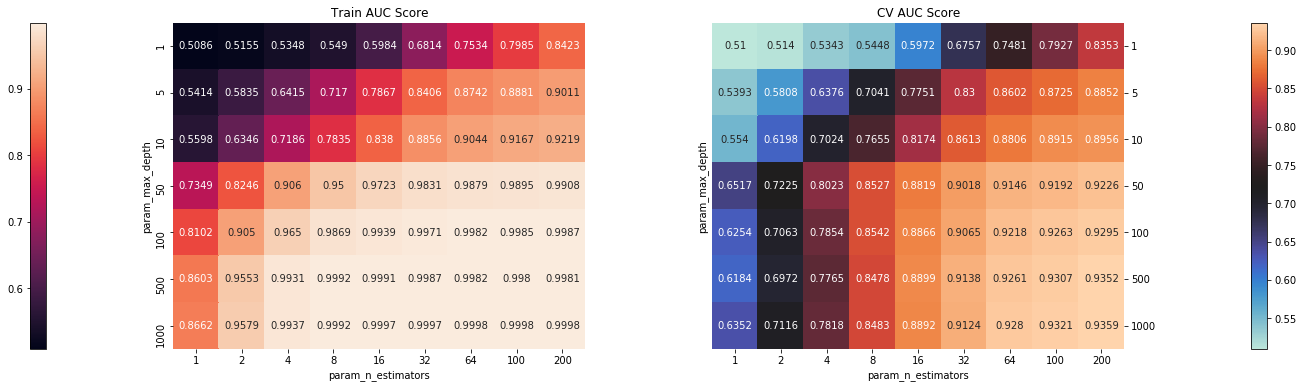

In [12]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

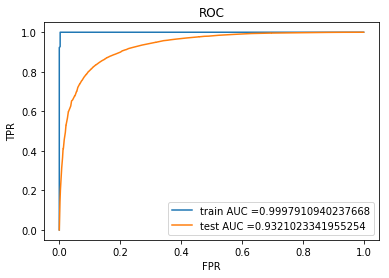

In [63]:
# Testing accuracy on test dataset
clf1 = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf1.fit(X_train_bow,y_train)

predTest  = clf1.predict_proba(X_test_bow)
predTrain = clf1.predict_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

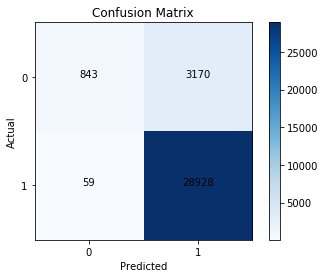

In [64]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf1.predict(X_test_bow))

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [65]:
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf1.feature_importances_
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [66]:
# Top 20 important features
sortedFeature[:20]

,feature,Probability
22013,not,0.013096
14406,great,0.006891
8478,disappointed,0.006311
22097,not buy,0.005915
37169,worst,0.005778
22794,not worth,0.004929
33349,terrible,0.004893
15715,horrible,0.004600
1884,awful,0.004161
37325,would not,0.004043


#### Feature Engineering
    - Adding review length as a extra feature.

In [69]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
X_train_bow_newF = preprocessing.normalize(X_train_bow_newF)
print("Old Dimension: "+str(X_train_bow.shape))
print("New Dimension: "+ str(X_train_bow_newF.shape))

Old Dimension: (67000, 37714)
New Dimension: (67000, 37715)


In [70]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
X_test_bow_newF = preprocessing.normalize(X_test_bow_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_bow_newF.shape))

Old Dimension: (33000, 37714)
New Dimension: (33000, 37715)


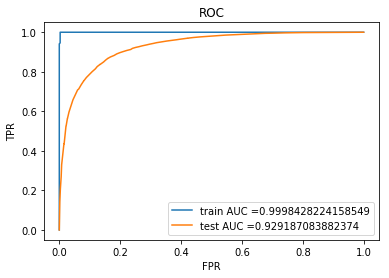

In [71]:
# Testing accuracy on test dataset
clf = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf.fit(X_train_bow_newF,y_train)

predTest  = clf.predict_proba(X_test_bow_newF)
predTrain = clf.predict_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

<b>Observation:</b>
    - Model accuracy nearly remains same after adding review length as a extra feature. 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [72]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_train_tfidf.shape)

Train Data Size:  (67000, 37714)
Test Data Size:  (67000, 37714)


In [73]:
# Model Training
clf = RandomForestClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_tfidf, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5217833180176892, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV]  max_depth=1, n_estimators=1, score=0.514632021642355, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5176207417923281, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5019971697181288, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5344353367002221, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.5031592766537032, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.5311033889443376, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.516340682582827, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.538989045547039, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.5219897475493335, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.5419619195863765, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.5389680529196549, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.5259292756852745, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.5128221626496421, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.5234627613973806, total=   0.2s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.5443392791968077, total=   0.3s
[CV] max_depth=1, n_estimators=8 ................

[CV]  max_depth=5, n_estimators=16, score=0.756111565416829, total=   0.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.7666836103922707, total=   0.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.7841206395648407, total=   0.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.7657611012361962, total=   0.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.7844500820480649, total=   0.4s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8210186916118976, total=   0.7s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8284528156226578, total=   0.7s
[CV] max_depth=5, n_estimators=32 .........

[CV]  max_depth=10, n_estimators=64, score=0.8754527457594145, total=   1.9s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8823458487808135, total=   2.2s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.870106684138357, total=   2.0s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8713102087095715, total=   2.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8959115216028894, total=   2.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8851304793958047, total=   2.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8942474676025429, total=   2.9s
[CV] max_depth=10, n_estimators=1

[CV]  max_depth=50, n_estimators=200, score=0.9212387446711862, total=  41.1s
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9222865775882674, total=  41.4s
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9223699712950354, total=  41.3s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6572852421420854, total=   0.7s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.5841378082354955, total=   0.6s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6358370411407929, total=   0.7s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.5996132027163611, total=   0.6s
[CV] max_depth=100, n_estimators

[CV]  max_depth=500, n_estimators=4, score=0.7715956764750677, total=   4.1s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7666050364762516, total=   4.1s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7889785794435002, total=   4.0s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7784637028311274, total=   4.1s
[CV] max_depth=500, n_estimators=8 ...................................
[CV]  max_depth=500, n_estimators=8, score=0.8459068537490286, total=   7.8s
[CV] max_depth=500, n_estimators=8 ...................................
[CV]  max_depth=500, n_estimators=8, score=0.8395673054035612, total=   7.4s
[CV] max_depth=500, n_estimators=8 ...................................
[CV]  max_depth=500, n_estimators=8, score=0.8499035382664691, total=   7.9s
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=16, score=0.8853776541077011, total=  16.7s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8872207963273953, total=  16.3s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8921129557575634, total=  15.5s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8801425173959014, total=  16.8s
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.9128814115754944, total=  32.2s
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.909930282047599, total=  32.3s
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.909591998967832, total=  33.5s
[CV] max_depth=1000, n_

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 104.7min finished


Best Hyperparameter: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the test set.

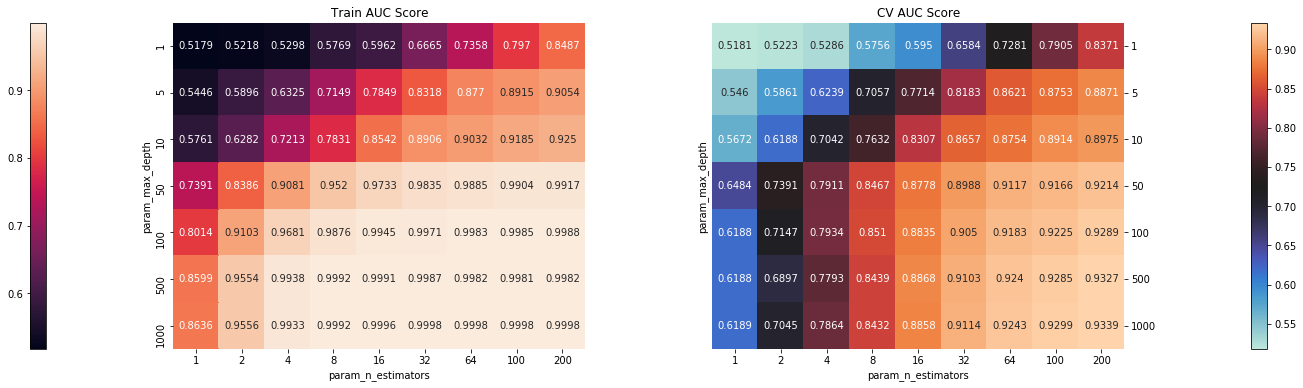

In [14]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

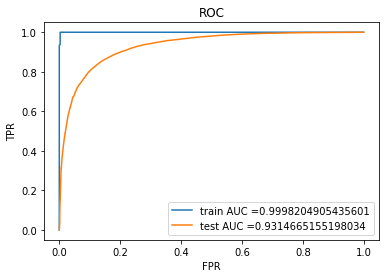

In [78]:
# Testing accuracy on test dataset
clf2 = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf2.fit(X_train_tfidf,y_train)

predTest  = clf2.predict_proba(X_test_tfidf)
predTrain = clf2.predict_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

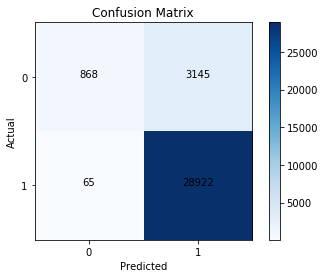

In [80]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf2.predict(X_test_tfidf))

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [81]:
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf2.feature_importances_
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [82]:
# Top 20 important features
sortedFeature[:20]

,feature,Probability
22013,not,0.012504
14406,great,0.006489
37169,worst,0.006082
8478,disappointed,0.005988
33349,terrible,0.005492
22097,not buy,0.005192
22794,not worth,0.005155
15715,horrible,0.004940
1884,awful,0.004784
30735,stale,0.004077


#### Feature Engineering

In [83]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
X_train_tfidf_newF = preprocessing.normalize(X_train_tfidf_newF)
print("Old Dimension: "+str(X_train_tfidf.shape))
print("New Dimension: "+ str(X_train_tfidf_newF.shape))

Old Dimension: (67000, 37714)
New Dimension: (67000, 37715)


In [84]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
X_test_tfidf_newF = preprocessing.normalize(X_test_tfidf_newF)
print("Old Dimension: "+str(X_test_tfidf.shape))
print("New Dimension: "+ str(X_test_tfidf_newF.shape))

Old Dimension: (33000, 37714)
New Dimension: (33000, 37715)


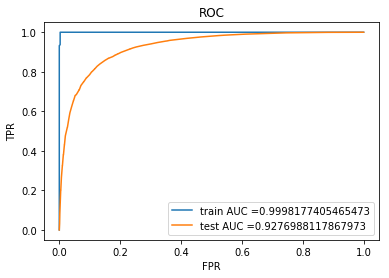

In [85]:
# Testing accuracy on test dataset
clf = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf.fit(X_train_tfidf_newF,y_train)

predTest  = clf.predict_proba(X_test_tfidf_newF)
predTrain = clf.predict_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()


<b>Observation:</b>
    - Model accuracy nearly remains same after adding review length as a extra feature. 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [19]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [20]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_trainText)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [21]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [91]:
# Vectorizing Train and Test data
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)
X_train_w2v = preprocessing.normalize(X_train_w2v)
print("Train Data Size: ",X_train_w2v.shape)
# Test Data
list_of_sentance_test = sentenceSplit(X_testText)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)
X_test_w2v = preprocessing.normalize(X_test_w2v)
print("Train Data Size: ",X_test_w2v.shape)

  0%|          | 0/33000 [00:00<?, ?it/s]

Train Data Size:  (67000, 150)


100%|██████████| 33000/33000 [00:13<00:00, 2391.55it/s]


Train Data Size:  (33000, 150)


In [92]:
# Model Training
clf = RandomForestClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_w2v, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5966755812714574, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV]  max_depth=1, n_estimators=1, score=0.6220610295616319, total=   0.1s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5892963286316932, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV]  max_depth=1, n_estimators=1, score=0.6153589399187912, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6658291979335065, total=   0.1s
[CV] max_depth=1, n_estimators=2 .....................................
[CV]  max_depth=1, n_estimators=2, score=0.6753119167114733, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6989329059379017, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6745271051236582, total=   0.3s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6474520090484879, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6500964789140495, total=   0.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7178776690489552, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7547152537014639, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7147968774861272, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7183709195343275, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.731427280584584, total=   0.4s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.7692673653952724, total=   0.7s
[CV] max_depth=1, n_estimators=8 .................

[CV]  max_depth=5, n_estimators=16, score=0.8737659296953201, total=   5.3s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8590574500493267, total=   5.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8635029371853311, total=   5.4s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8733315071787158, total=   5.5s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.867014698121484, total=   5.4s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.879503190936656, total=  10.6s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8682351411289035, total=  10.6s
[CV] max_depth=5, n_estimators=32 ..........

[CV]  max_depth=10, n_estimators=64, score=0.8890607247600485, total=  36.3s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8953868352018705, total=  36.3s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8983336880465961, total=  36.4s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8980741750802796, total=  37.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9027356045138664, total=  57.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8924337901510138, total=  57.4s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8952920789773293, total=  57.5s
[CV] max_depth=10, n_estimators=

[CV]  max_depth=50, n_estimators=200, score=0.9033371864439756, total= 3.3min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9075674981186792, total= 3.3min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9072113928125606, total= 3.2min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6227647368680287, total=   1.2s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6287667159144139, total=   1.1s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6294368223822138, total=   1.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6220710635025419, total=   1.1s
[CV] max_depth=100, n_estimators

[CV]  max_depth=500, n_estimators=2, score=0.6947656541459071, total=   2.0s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.7038951640827249, total=   2.1s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7598367291884301, total=   3.9s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7747595643089094, total=   4.2s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7780990334968148, total=   4.2s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7643241516217717, total=   3.9s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7704284162857108, total=   4.1s
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=8, score=0.8272514186983798, total=   8.1s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8628635542007903, total=  16.2s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8628632708321784, total=  15.6s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8619422676447529, total=  16.1s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.867818835150517, total=  15.5s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8644615617653749, total=  15.6s
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.8885496823489382, total=  32.1s
[CV] max_depth=1000, n_

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 178.3min finished


Best Hyperparameter: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the test set.

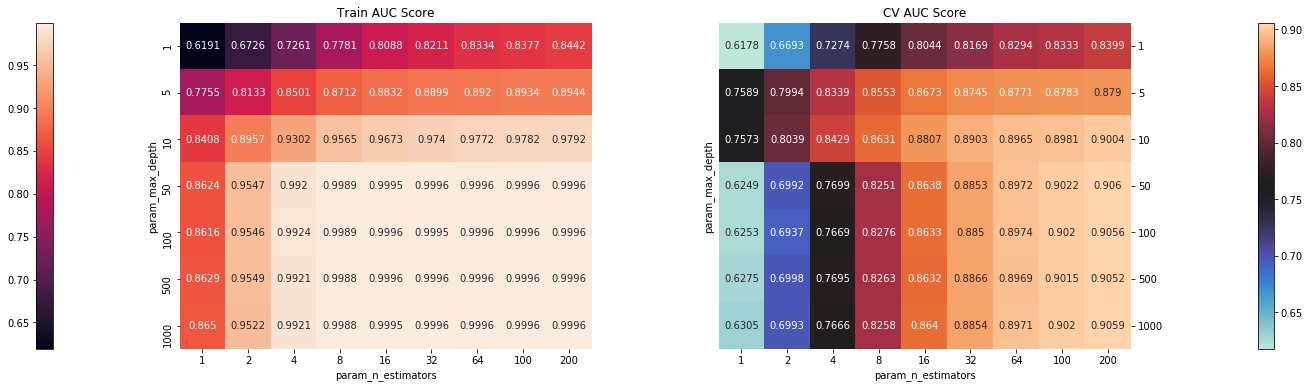

In [16]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

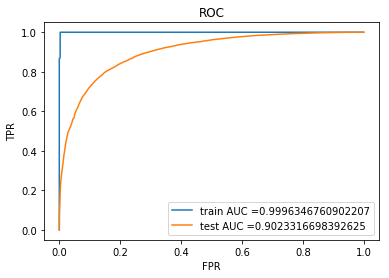

In [98]:
# Testing accuracy on test dataset
clf3 = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf3.fit(X_train_w2v,y_train)

predTest  = clf3.predict_proba(X_test_w2v)
predTrain = clf3.predict_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

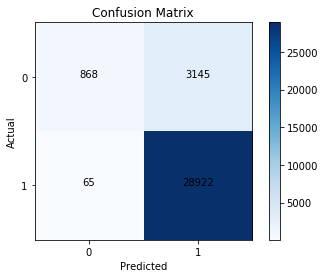

In [99]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf2.predict(X_test_tfidf))

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [16]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_trainText:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_testText:
    sent_of_test.append(sent.split()) 

In [22]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf_AW2V = []
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 67000/67000 [57:34<00:00, 16.26it/s]  


In [23]:
# TFIDF-Word2Vec for test data .
X_test_tfidf_AW2V = []
X_test_tfidf = vectorizer.transform(X_testText)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 33000/33000 [27:51<00:00, 19.75it/s]  


In [24]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V) 
print(X_train_tfidf_AW2V.shape)
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)
print(X_test_tfidf_AW2V.shape)

(67000, 150)
(33000, 150)


In [26]:
# Model Training
clf = RandomForestClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]}

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_tfidf_AW2V, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.5821678307051832, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV]  max_depth=1, n_estimators=1, score=0.6001605084734419, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6205206548511459, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................
[CV]  max_depth=1, n_estimators=1, score=0.6089184063102377, total=   0.2s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.559154713937674, total=   0.2s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6071585179090141, total=   0.3s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6407645089285715, total=   0.3s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6498132682403218, total=   0.3s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6438088154583422, total=   0.3s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6277884007215143, total=   0.3s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.707138470036745, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7085740054080103, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7064406639453711, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6946650488929642, total=   0.4s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6972441077870662, total=   0.4s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.7203760267606152, total=   0.8s
[CV] max_depth=1, n_estimators=8 .................

[CV]  max_depth=5, n_estimators=16, score=0.8386359101420272, total=   5.7s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8422143298467955, total=   5.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8428641339904824, total=   5.7s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8506576266833101, total=   5.7s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8355923879578068, total=   5.6s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8473683428932856, total=  11.2s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8511461955266786, total=  12.0s
[CV] max_depth=5, n_estimators=32 ........

[CV]  max_depth=10, n_estimators=64, score=0.8749348208847585, total=  38.5s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8775964452204701, total=  37.9s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8830444048344133, total=  37.7s
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8703954994461475, total=  37.6s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8739538399048244, total=  59.0s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8786611943051912, total=  59.3s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8788109781604734, total= 1.0min
[CV] max_depth=10, n_estimators=

[CV]  max_depth=50, n_estimators=200, score=0.8896074423725636, total= 3.7min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.8900604803624975, total= 3.7min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.8798009006796824, total= 3.7min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6115371269443404, total=   1.2s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6055651983578523, total=   1.1s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6133437100506666, total=   1.2s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.6083989081073302, total=   1.3s
[CV] max_depth=100, n_estimators

[CV]  max_depth=500, n_estimators=2, score=0.6800418411748368, total=   2.4s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.6757287249929722, total=   2.2s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7427192078486426, total=   4.4s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7293178013392858, total=   4.3s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7475505149908305, total=   4.5s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7461298821850235, total=   4.8s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7398187502928223, total=   4.4s
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=8, score=0.7881401880672387, total=   8.8s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8357899123122591, total=  17.7s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8359561674241004, total=  18.0s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8395449404901343, total=  17.5s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8501781039586233, total=  17.3s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8339683743507711, total=  17.0s
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.857348041938852, total=  35.3s
[CV] max_depth=1000, n_

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 196.7min finished


Best Hyperparameter: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the test set.

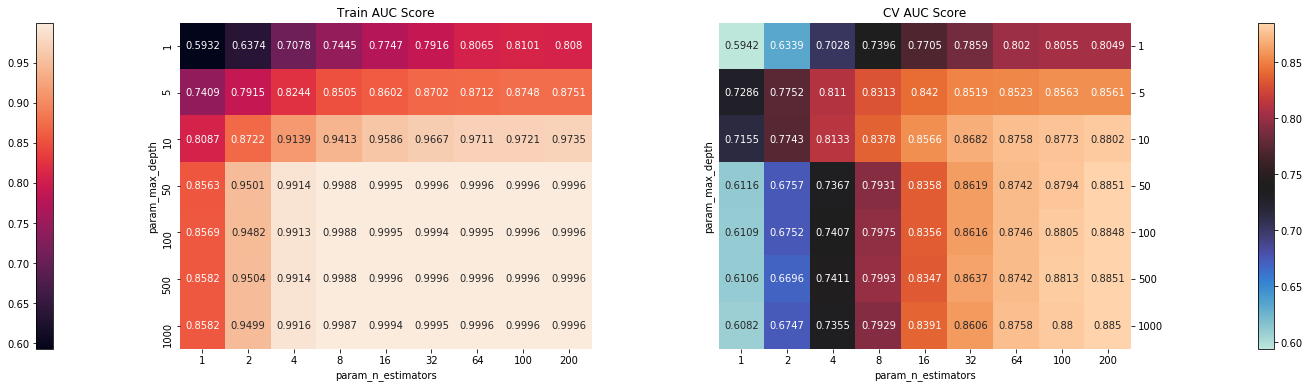

In [18]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

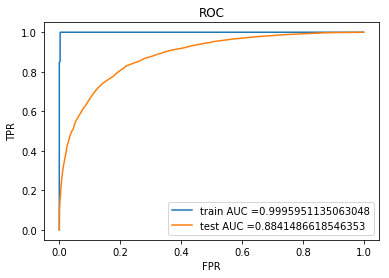

In [30]:
# Testing accuracy on test dataset
clf4 = RandomForestClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf4.fit(X_train_tfidf_AW2V,y_train)

predTest  = clf4.predict_proba(X_test_tfidf_AW2V)
predTrain = clf4.predict_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

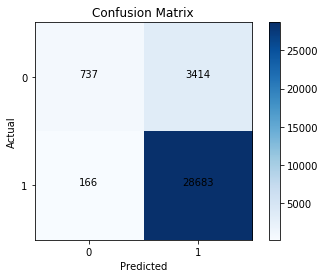

In [34]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf4.predict(X_test_tfidf_AW2V))

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [10]:
# BOW vectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (67000, 37777)
Test Data Size:   (33000, 37777)


In [11]:
# Model Training
clf = XGBClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_bow, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.6062627488202031, total=   1.9s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5982006745404246, total=   1.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5879826907190422, total=   1.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.603011309260146, total=   1.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.597620076508123, total=   1.8s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6189365153811819, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6335642771234852, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6082667951261809, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6350742067780533, total=   1.8s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6118874872178997, total=   1.9s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6366397513749622, total=   2.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6479875273463032, total=   2.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6406769698983783, total=   2.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6391925113639854, total=   2.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6415327874140654, total=   2.1s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.6988914564186287, total=   2.5s
[CV] max_depth=1, n_estimators=8 ................

[CV]  max_depth=5, n_estimators=16, score=0.817291730906405, total=   9.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8207555272952202, total=   9.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8021029271558233, total=   9.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8107803424541344, total=   9.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8048499477791557, total=   9.6s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.852497656472554, total=  17.4s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8520558827533888, total=  17.4s
[CV] max_depth=5, n_estimators=32 ..........

[CV]  max_depth=10, n_estimators=64, score=0.9064693195583808, total= 1.1min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9074585732156436, total= 1.1min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9222675221803467, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9233205389402499, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.921525702897925, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9190145863835, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9214118549870339, total= 1.7min
[CV] max_depth=10, n_estimators=20

[CV]  max_depth=50, n_estimators=200, score=0.9426803061973889, total=14.3min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.783238284268077, total=  11.9s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7922650617597496, total=  11.8s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7669046649024083, total=  11.9s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7780176371856109, total=  11.8s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7789663879974713, total=  11.8s
[CV] max_depth=100, n_estimators=2 ...................................
[CV]  max_depth=100, n_estimators=2, score=0.8128206451224865, total=  21.9s
[CV] max_depth=100, n_estimators=2 

[CV]  max_depth=500, n_estimators=4, score=0.8379758709878615, total= 1.9min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8403235695110529, total= 1.5min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8381910949602867, total= 1.5min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8386024735386564, total= 1.6min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8462000292280074, total= 1.7min
[CV] max_depth=500, n_estimators=8 ...................................
[CV]  max_depth=500, n_estimators=8, score=0.8706649634253174, total= 3.1min
[CV] max_depth=500, n_estimators=8 ...................................
[CV]  max_depth=500, n_estimators=8, score=0.8662079357163883, total= 2.7min
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=16, score=0.8867975056340439, total= 4.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8876649254284382, total= 4.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8872613088994336, total= 4.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8887143355956525, total= 4.5min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.9079257109523835, total= 7.0min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.9060108003092159, total= 6.7min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.905398199002142, total= 6.7min
[CV] max_depth=1000, n

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 1257.3min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the test set.


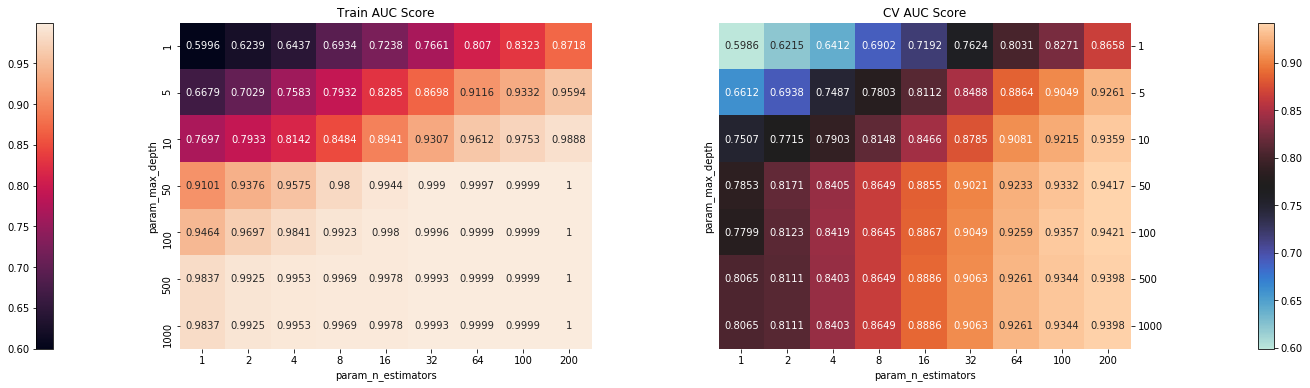

In [10]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

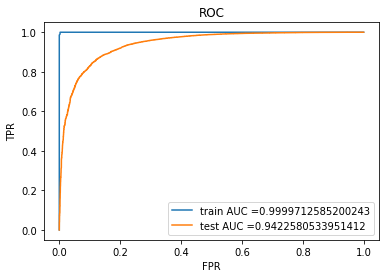

In [17]:
# Testing accuracy on test dataset
clf1 = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf1.fit(X_train_bow,y_train)

predTest  = clf1.predict_proba(X_test_bow)
predTrain = clf1.predict_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

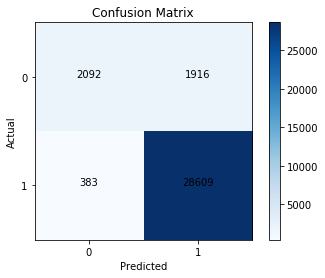

In [20]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf1.predict(X_test_bow))

#### Feature Importance

In [26]:
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf1.feature_importances_
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [27]:
# Top 20 important features
sortedFeature[:20]

,feature,Probability
37221,worst,0.002326
23201,okay not,0.002074
19874,many dogs,0.002072
2520,behind,0.002000
31595,sucrose,0.001992
22251,not disappointed,0.001902
33386,terrible,0.001803
4860,cartons,0.001789
11162,finally got,0.001768
21822,no aroma,0.001739


#### Feature Engineering
    - Adding review length as a extra feature.

In [28]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
X_train_bow_newF = preprocessing.normalize(X_train_bow_newF)
print("Old Dimension: "+str(X_train_bow.shape))
print("New Dimension: "+ str(X_train_bow_newF.shape))

Old Dimension: (67000, 37777)
New Dimension: (67000, 37778)


In [29]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
X_test_bow_newF = preprocessing.normalize(X_test_bow_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_bow_newF.shape))

Old Dimension: (33000, 37777)
New Dimension: (33000, 37778)


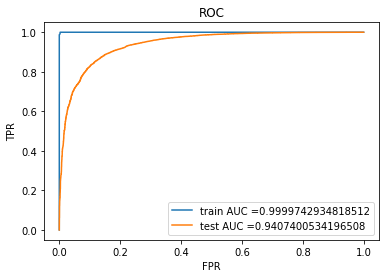

In [30]:
# Testing accuracy on test dataset
clf = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf.fit(X_train_bow_newF,y_train)

predTest  = clf.predict_proba(X_test_bow_newF)
predTrain = clf.predict_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

<b>Observation:</b>
    - Model accuracy nearly remains same after adding review length as a extra feature. 

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [11]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_train_tfidf.shape)

Train Data Size:  (67000, 37497)
Test Data Size:  (67000, 37497)


In [13]:
# Model Training
clf = XGBClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_tfidf, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.6000999014527356, total=   1.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5985554237390234, total=   1.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6017181141572071, total=   1.9s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.5913885969961448, total=   1.9s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6182562798862814, total=   1.8s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6213259145424559, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6217511361506747, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6290262025795137, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6144547616677152, total=   1.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6246554601482762, total=   1.9s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6324030442990032, total=   2.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6315308270808793, total=   2.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6490268049568966, total=   2.2s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6446694516859873, total=   2.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6606573108792761, total=   2.1s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.6727182763347277, total=   2.6s
[CV] max_depth=1, n_estimators=8 ................

[CV]  max_depth=5, n_estimators=16, score=0.7984744519563263, total=  10.3s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8091648581401264, total=  10.2s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.814916385626941, total=  10.2s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8048831942148345, total=  10.3s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.808846543362734, total=  10.3s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8409797045338852, total=  19.0s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8506846343150969, total=  18.9s
[CV] max_depth=5, n_estimators=32 ..........

[CV]  max_depth=10, n_estimators=64, score=0.9071381667564655, total= 1.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.915281555999344, total= 1.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9029732918836341, total= 1.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9099804483444507, total= 1.2min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9200915169879005, total= 1.8min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.920435412176724, total= 1.8min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9281577908729788, total= 1.8min
[CV] max_depth=10, n_estimators=10

[CV]  max_depth=50, n_estimators=200, score=0.944377350945063, total=15.1min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.938162118368829, total=15.0min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9425449058121702, total=15.2min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7607363605524837, total=  12.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7783516340323142, total=  12.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.779934469497952, total=  12.2s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7882012101510629, total=  12.0s
[CV] max_depth=100, n_estimators=1 

[CV]  max_depth=500, n_estimators=2, score=0.8090012175134531, total=  53.6s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.8138188525091081, total=  55.5s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8334926378166344, total= 1.6min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8235573113973147, total= 1.5min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.830772558405507, total= 1.7min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8282354619983535, total= 1.5min
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8333591280405316, total= 1.6min
[CV] max_depth=500, n_estimators=8 .

[CV]  max_depth=1000, n_estimators=8, score=0.8613836123975327, total= 2.9min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8814231923206751, total= 4.6min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8782030057794764, total= 4.4min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8830730334470043, total= 4.6min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8859983286119217, total= 4.4min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8876858422322458, total= 4.5min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.9006869656184657, total= 6.9min
[CV] max_depth=1000, n

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 1269.4min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the train and test set.


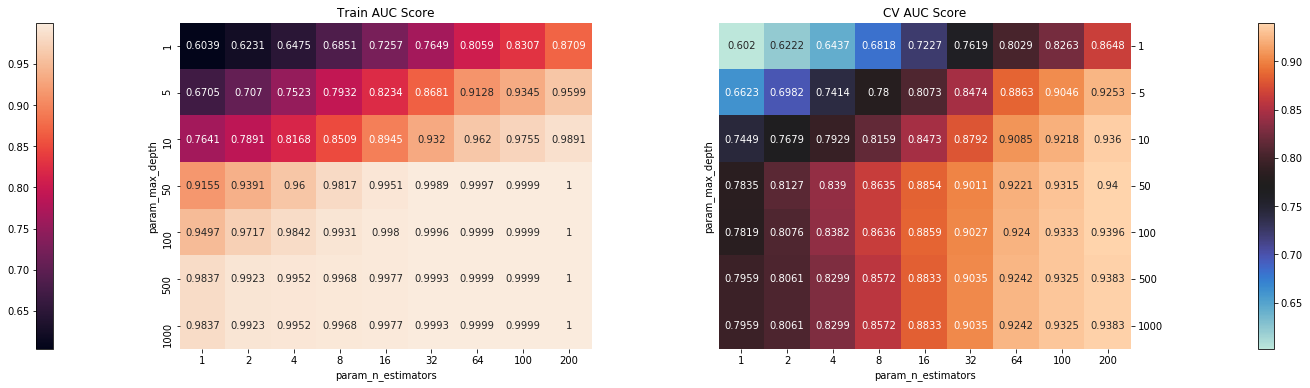

In [29]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

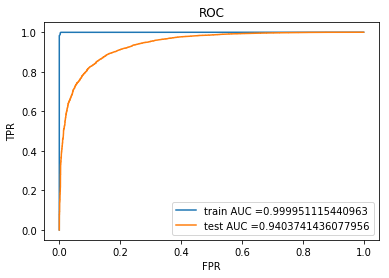

In [32]:
# Testing accuracy on test dataset
clf2 = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf2.fit(X_train_tfidf,y_train)

predTest  = clf2.predict_proba(X_test_tfidf)
predTrain = clf2.predict_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

In [42]:
featureProb = pd.DataFrame(
    {'Feature': vectorizer.get_feature_names(),
     'Score': clf2.feature_importances_
    })

sortedFeature = featureProb.sort_values('Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [43]:
# Top 20 important features
sortedFeature[:20]

,Feature,Score
21413,never purchase,0.003200
27324,refund,0.003045
22075,not disappointed,0.002852
36967,worst,0.002755
15400,high fructose,0.002382
20703,money back,0.002374
82,according,0.002285
24566,perfect,0.002241
33471,think twice,0.002209
14154,got bad,0.002146


#### Feature Engineering
    - Adding review length as a extra feature.

In [39]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
X_train_tfidf_newF = preprocessing.normalize(X_train_tfidf_newF)
print("Old Dimension: "+str(X_train_tfidf.shape))
print("New Dimension: "+ str(X_train_tfidf_newF.shape))

Old Dimension: (67000, 37497)
New Dimension: (67000, 37498)


In [40]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
X_test_tfidf_newF = preprocessing.normalize(X_test_tfidf_newF)
print("Old Dimension: "+str(X_test_tfidf.shape))
print("New Dimension: "+ str(X_test_tfidf_newF.shape))

Old Dimension: (33000, 37497)
New Dimension: (33000, 37498)


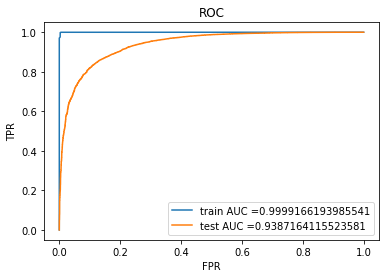

In [41]:
# Testing accuracy on test dataset
clf = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf.fit(X_train_tfidf_newF,y_train)

predTest  = clf.predict_proba(X_test_tfidf_newF)
predTrain = clf.predict_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

<b>Observation:</b>
    - Model accuracy nearly remains same after adding review length as a extra feature. 

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [21]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [22]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_trainText)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [23]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [24]:
# Vectorizing Train and Test data
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)
X_train_w2v = preprocessing.normalize(X_train_w2v)
print("Train Data Size: ",X_train_w2v.shape)
# Test Data
list_of_sentance_test = sentenceSplit(X_testText)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)
X_test_w2v = preprocessing.normalize(X_test_w2v)
print("Train Data Size: ",X_test_w2v.shape)

  0%|          | 0/33000 [00:00<?, ?it/s]

Train Data Size:  (67000, 150)


100%|██████████| 33000/33000 [00:14<00:00, 2310.01it/s]


Train Data Size:  (33000, 150)


In [25]:
# Model Training
clf = XGBClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_w2v, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.6410704674837376, total=   1.4s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6520241959470489, total=   1.4s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6677415283837512, total=   1.3s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6398049581855523, total=   1.5s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6560958141260214, total=   1.4s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.7006273829687196, total=   1.7s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.7174840706804928, total=   1.6s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.7192119703785355, total=   1.5s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.7285226443533246, total=   1.6s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.7072247380849048, total=   1.6s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7185889464574663, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.729352821222877, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7353557844055705, total=   1.9s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7499747012517729, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.7294854321759271, total=   2.0s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.7434731515826556, total=   2.7s
[CV] max_depth=1, n_estimators=8 .................

[CV]  max_depth=5, n_estimators=16, score=0.8627168986286784, total=  14.8s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8814493777603964, total=  14.9s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8688995741150704, total=  14.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8805390545516882, total=  14.7s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8734597112179929, total=  14.6s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.88282223105861, total=  28.9s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8982405695324056, total=  29.0s
[CV] max_depth=5, n_estimators=32 ..........

[CV]  max_depth=10, n_estimators=64, score=0.9134043524139543, total= 2.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9079266809906381, total= 2.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9120283577693096, total= 2.1min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.9054788271264509, total= 2.2min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9101610610987725, total= 3.4min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9171243271233517, total= 3.4min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.9112673690456639, total= 3.4min
[CV] max_depth=10, n_estimators=

[CV]  max_depth=50, n_estimators=200, score=0.9160695440503132, total=10.3min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9202714691534182, total=10.5min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9141137230765697, total=10.4min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7541478627319855, total=   7.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7453659509431568, total=   7.3s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7748772128495824, total=   7.3s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7794223160283743, total=   7.8s
[CV] max_depth=100, n_estimators

[CV]  max_depth=500, n_estimators=2, score=0.8170280978611972, total=  12.9s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.8258734578657166, total=  12.7s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8365178823638619, total=  23.0s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8315271019995909, total=  26.2s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8371952285961092, total=  23.4s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8499712460630584, total=  24.3s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8461172239927074, total=  24.5s
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=8, score=0.8622201463749174, total=  49.5s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8775950044604861, total= 1.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8817575442255121, total= 1.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8801654258777534, total= 1.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8887057314198766, total= 1.5min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8840518382885558, total= 1.6min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.8927103249571957, total= 2.7min
[CV] max_depth=1000, n

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 650.5min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the train and test set.


In [28]:
saveModel('XGBoost_W2V_model.pkl',model)

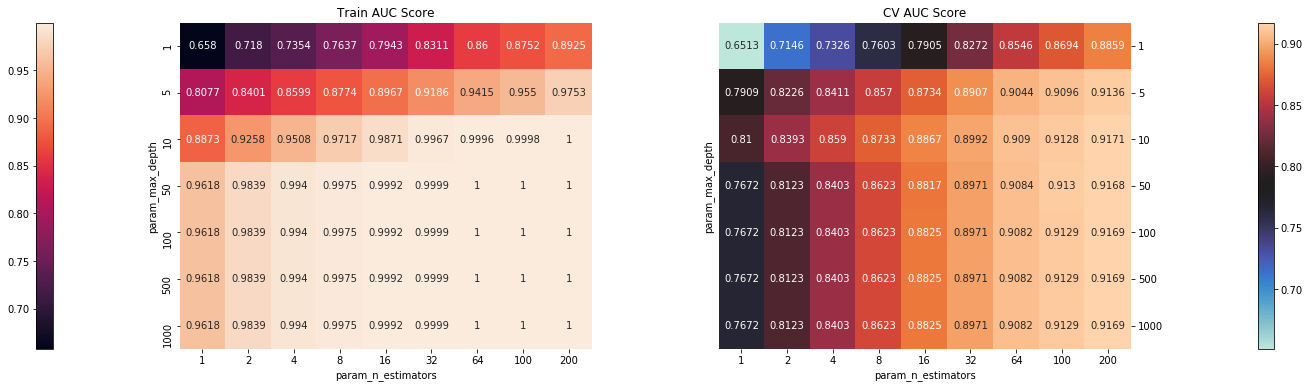

In [29]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

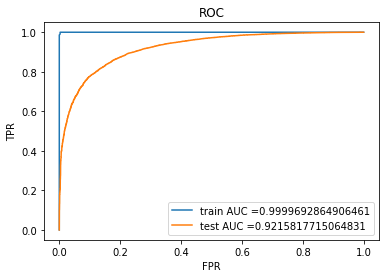

In [31]:
# Testing accuracy on test dataset
clf3 = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf3.fit(X_train_w2v,y_train)

predTest  = clf3.predict_proba(X_test_w2v)
predTrain = clf3.predict_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

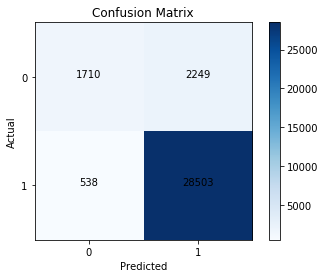

In [34]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf3.predict(X_test_w2v))

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [35]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_trainText:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_testText:
    sent_of_test.append(sent.split()) 

In [36]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf_AW2V = []
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 67000/67000 [1:08:59<00:00, 16.18it/s]


In [37]:
# TFIDF-Word2Vec for test data .
X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_testText)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 33000/33000 [33:51<00:00, 16.24it/s]  


In [38]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V) 
print(X_train_tfidf_AW2V.shape)
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)
print(X_test_tfidf_AW2V.shape)

(67000, 150)
(33000, 150)


In [39]:
# Model Training
clf = XGBClassifier()
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='roc_auc')
model.fit(X_train_tfidf_AW2V, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.6236597665998268, total=   1.5s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6344960019557082, total=   1.5s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6428090833580916, total=   1.3s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6510929930720903, total=   1.4s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.6499894601365036, total=   1.6s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6759472475158417, total=   1.7s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6889029693917521, total=   1.6s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.7s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6846168675938906, total=   1.5s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6917491836475862, total=   1.6s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.6887618807996804, total=   1.6s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6797801047463732, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6928406662317689, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6861223865056951, total=   1.9s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6941407740258392, total=   2.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.6927141501871081, total=   1.9s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.7068224228589999, total=   2.7s
[CV] max_depth=1, n_estimators=8 ................

[CV]  max_depth=5, n_estimators=16, score=0.8344403521791219, total=  14.8s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8469820177913304, total=  14.6s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.842439696715636, total=  14.5s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8565431534102765, total=  14.7s
[CV] max_depth=5, n_estimators=16 ....................................
[CV]  max_depth=5, n_estimators=16, score=0.8464343426482965, total=  14.6s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.8553653956236519, total=  29.1s
[CV] max_depth=5, n_estimators=32 ....................................
[CV]  max_depth=5, n_estimators=32, score=0.869073027281249, total=  31.0s
[CV] max_depth=5, n_estimators=32 ..........

[CV]  max_depth=10, n_estimators=64, score=0.8951313950496852, total= 2.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8894609626668422, total= 2.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8913125533977885, total= 2.2min
[CV] max_depth=10, n_estimators=64 ...................................
[CV]  max_depth=10, n_estimators=64, score=0.8891251985067432, total= 2.2min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8884183045603717, total= 3.4min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8986779861000045, total= 3.4min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8932704706591301, total= 3.4min
[CV] max_depth=10, n_estimators=

[CV]  max_depth=50, n_estimators=200, score=0.8966257933185828, total=11.0min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.9023122286920716, total=11.0min
[CV] max_depth=50, n_estimators=200 ..................................
[CV]  max_depth=50, n_estimators=200, score=0.8952984262897005, total=11.0min
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7310552545981122, total=   8.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7194529703292378, total=   8.0s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7345166654056814, total=   8.3s
[CV] max_depth=100, n_estimators=1 ...................................
[CV]  max_depth=100, n_estimators=1, score=0.7360997604231613, total=   7.8s
[CV] max_depth=100, n_estimators

[CV]  max_depth=500, n_estimators=2, score=0.7886804531772204, total=  13.4s
[CV] max_depth=500, n_estimators=2 ...................................
[CV]  max_depth=500, n_estimators=2, score=0.7702969780837483, total=  13.0s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7999207132843389, total=  26.1s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8129331197573151, total=  27.5s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8036524333220768, total=  27.3s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.8208108630723068, total=  25.6s
[CV] max_depth=500, n_estimators=4 ...................................
[CV]  max_depth=500, n_estimators=4, score=0.7949938109060315, total=  26.0s
[CV] max_depth=500, n_estimators=8 

[CV]  max_depth=1000, n_estimators=8, score=0.8281096160157531, total=  52.7s
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8513671464169545, total= 1.7min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8646080842839765, total= 1.7min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8536389879394457, total= 1.7min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8662978329610034, total= 1.6min
[CV] max_depth=1000, n_estimators=16 .................................
[CV]  max_depth=1000, n_estimators=16, score=0.8529340191216499, total= 1.7min
[CV] max_depth=1000, n_estimators=32 .................................
[CV]  max_depth=1000, n_estimators=32, score=0.8702976758444313, total= 2.9min
[CV] max_depth=1000, n

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 687.5min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


<br>
Heatmap  of <B>max_depth</B> and <B>n_estimators</B> parameters to find the areas where the maximum AUC is achieved in the train and test set.


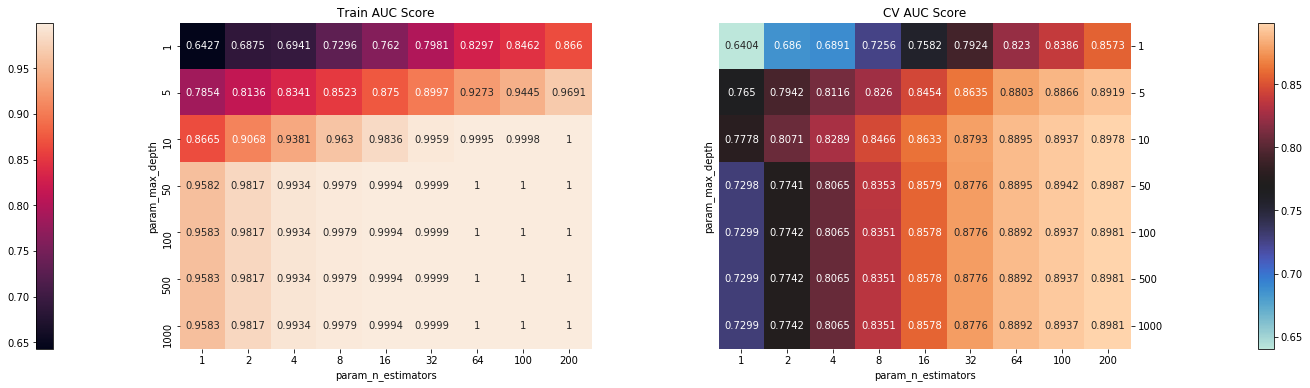

In [42]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1
# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train AUC Score')
ax2.title.set_text('CV AUC Score')
plt.show()

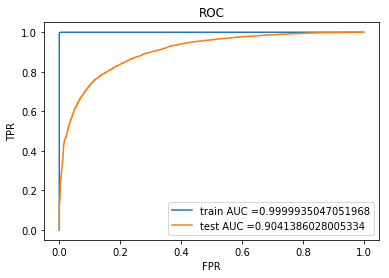

In [43]:
# Testing accuracy on test dataset
clf4 = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf4.fit(X_train_tfidf_AW2V,y_train)

predTest  = clf4.predict_proba(X_test_tfidf_AW2V)
predTrain = clf4.predict_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

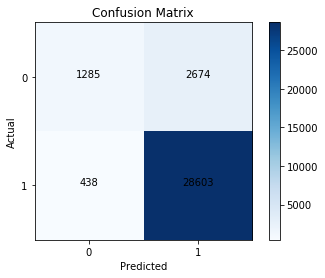

In [44]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf4.predict(X_test_tfidf_AW2V))

# [6] Conclusions

### XGBoost

In [45]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter: max_depth, n_estimators", "AUC"]
x.add_row(["BOW", "XGBoost","100, 200",0.9422])
x.add_row(["TFIDF", "XGBoost","50, 200" , 0.9403])
x.add_row(["Average W2v","XGBoost","10, 200", 0.9251])
x.add_row(["TFIDF-W2v", "XGBoost","50, 200",0.9041 ])
print(x)

+-------------+---------+-----------------------------------------+--------+
|  Vectorizer |  Model  | Hyperparameter: max_depth, n_estimators |  AUC   |
+-------------+---------+-----------------------------------------+--------+
|     BOW     | XGBoost |                 100, 200                | 0.9422 |
|    TFIDF    | XGBoost |                 50, 200                 | 0.9403 |
| Average W2v | XGBoost |                 10, 200                 | 0.9251 |
|  TFIDF-W2v  | XGBoost |                 50, 200                 | 0.9041 |
+-------------+---------+-----------------------------------------+--------+


### Random Forest

In [47]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter: max_depth, n_estimators", "AUC"]
x.add_row(["BOW", "Random Forest","1000, 200",0.9321])
x.add_row(["TFIDF", "Random Forest","1000, 200" , 0.9314])
x.add_row(["Average W2v","Random Forest","50, 200", 0.9023])
x.add_row(["TFIDF-W2v", "Random Forest","500, 200",0.8841 ])
print(x)

+-------------+---------------+-----------------------------------------+--------+
|  Vectorizer |     Model     | Hyperparameter: max_depth, n_estimators |  AUC   |
+-------------+---------------+-----------------------------------------+--------+
|     BOW     | Random Forest |                1000, 200                | 0.9321 |
|    TFIDF    | Random Forest |                1000, 200                | 0.9314 |
| Average W2v | Random Forest |                 50, 200                 | 0.9023 |
|  TFIDF-W2v  | Random Forest |                 500, 200                | 0.8841 |
+-------------+---------------+-----------------------------------------+--------+
